<a href="https://colab.research.google.com/github/DavidLicerio/Repo/blob/master/MCMC_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install pymc3
!pip install featurewiz
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 487 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 872 kB 8.3 MB/s 
     |████████████████████████████████| 1.8 MB 26.5 MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=b4beef1c603f90cf1f135297474e8e53becd0ada68819ccb282b53ef17843d89
  Stored in directory: /root/.cache/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built theano-pymc
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 111 kB 12.5 MB/s 
     |█████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 12.1 MB/s 


In [ ]:
from pandas_datareader.famafrench import get_available_datasets
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
from scipy import stats
import pandas_datareader.data as web
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import shap
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score
import yfinance as yf 
import theano
import pymc3 as pm
import arviz
from pymc3.variational.callbacks import CheckParametersConvergence
import statsmodels.formula.api as smf
from datetime import date
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
from IPython.display import HTML
sns.set_style('darkgrid')
import pandas as pd 
import numpy as np 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score 
from featurewiz import featurewiz


Imported 0.2.03 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



In [ ]:
#get industry data
datasets = get_available_datasets()
df_30_industry = [dataset for dataset in datasets if '30' in dataset and 'Industry' in dataset]
ds_industry = web.DataReader(df_30_industry[0],'famafrench',start='1971-01-01',end='2022-11-1')

In [ ]:
print(type(ds_industry))
ds_industry.keys()


<class 'dict'>


dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 'DESCR'])

In [ ]:
print(ds_industry['DESCR'])

30 Industry Portfolios
----------------------

This file was created by CMPT_IND_RETS using the 202210 CRSP database. It contains value- and equal-weighted returns for 30 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2022 Kenneth R. French

  0 : Average Value Weighted Returns -- Monthly (622 rows x 30 cols)
  1 : Average Equal Weighted Returns -- Monthly (622 rows x 30 cols)
  2 : Average Value Weighted Returns -- Annual (51 rows x 30 cols)
  3 : Average Equal Weighted Returns -- Annual (51 rows x 30 cols)
  4 : Number of Firms in Portfolios (622 rows x 30 cols)
  5 : Average Firm Size (622 rows x 30 cols)
  6 : Sum of BE / Sum of ME (52 rows x 30 cols)
  7 : Value-Weighted Average of BE/ME (52 rows x 30 cols)


In [ ]:
industry_ports = ds_industry[0]#.head()
industry_ports

Food   Beer   Smoke  Games  Books  Hshld  Clths  Hlth   Chems  Txtls  \
Date                                                                            
1971-01   2.73   4.51   5.75  11.53   5.59   5.15  12.63   4.92   7.00   6.27   
1971-02   2.36   1.66   5.07   5.90   7.11   1.69   6.05   1.31   1.79   6.36   
1971-03   4.09   2.66   9.61  11.13   4.47   6.36   4.29   3.68   3.17  -0.38   
1971-04   1.76   1.50   1.73   6.62   5.40   3.82   2.82   4.23   6.44  -0.03   
1971-05  -1.51  -1.69  -7.71  -0.78  -6.34  -1.07  -4.10  -2.13  -0.84  -3.56   
...        ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
2022-06  -1.64  -0.02 -11.63 -11.33 -12.53  -2.56 -12.00  -2.05 -15.65 -11.17   
2022-07   3.67   5.49   0.56  14.62  12.10   0.76  11.86   2.75   7.66   6.86   
2022-08  -1.60  -1.87  -0.12  -2.95  -4.97  -2.16  -6.01  -5.07  -1.38 -12.20   
2022-09  -7.79  -5.21 -10.55  -6.24 -13.42 -10.60 -17.36  -1.91 -11.25 -15.53   
2022-10   9.87   9.39  12.08  13.36   8.82   5.68  10.72   8.84   8.94   8.37   

         ...  Telcm  Servs  BusEq  Paper  Trans  Whlsl  Rtail  Meals  Fin    \
Date     ...                                                                  
1971-01  ...   9.75   8.62   5.33   4.66  15.83  13.94   7.87   7.78   5.22   
1971-02  ...  -5.30   3.76   2.75   2.08   2.76   1.88   3.62   6.09   1.87   
1971-03  ...   0.73   7.67   8.10   3.31   3.04   9.18   6.37   9.87   7.20   
1971-04  ...   0.82   2.35   2.29   1.97  11.61   1.60   5.54   2.83   2.28   
1971-05  ...  -5.21  -3.94  -6.23  -3.03  -3.67  -3.10  -1.98   2.20  -5.40   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
2022-06  ...  -6.72  -6.79 -10.19  -8.51  -7.14  -6.43  -8.50  -9.02  -9.05   
2022-07  ...  -0.40   8.60  15.68   7.22   9.33   9.08  16.33  11.89   7.38   
2022-08  ...  -3.01  -4.70  -5.89  -7.66  -1.46  -1.60  -3.46  -1.47  -2.24   
2022-09  ... -13.94 -11.07 -11.54 -13.27 -14.24  -9.46  -7.67  -6.26  -7.73   
2022-10  ...  10.94   1.99   8.97  10.02   6.68  13.65   1.94  10.26  12.80   

         Other  
Date            
1971-01  14.19  
1971-02   2.82  
1971-03   1.86  
1971-04   6.70  
1971-05  -7.20  
...        ...  
2022-06 -11.78  
2022-07   9.19  
2022-08  -3.65  
2022-09  -6.40  
2022-10  11.25  

[622 rows x 30 columns]

In [ ]:
df_5_factor = [dataset for dataset in datasets if '5' in dataset and 'Factor' in dataset]
print(df_5_factor)
ds_factors = web.DataReader(df_5_factor[0],'famafrench',start='1971-01-01',end='2022-11-1') # Taking [0] as extracting 1F-F-Research_Data_Factors_2x3')
print('\nKEYS\n{0}'.format(ds_factors.keys()))
print('DATASET DESCRIPTION \n {0}'.format(ds_factors['DESCR']))
ds_factors[0].head()

['F-F_Research_Data_5_Factors_2x3', 'F-F_Research_Data_5_Factors_2x3_daily', 'Developed_5_Factors', 'Developed_5_Factors_Daily', 'Developed_ex_US_5_Factors', 'Developed_ex_US_5_Factors_Daily', 'Europe_5_Factors', 'Europe_5_Factors_Daily', 'Japan_5_Factors', 'Japan_5_Factors_Daily', 'Asia_Pacific_ex_Japan_5_Factors', 'Asia_Pacific_ex_Japan_5_Factors_Daily', 'North_America_5_Factors', 'North_America_5_Factors_Daily', 'Emerging_5_Factors']

KEYS
dict_keys([0, 1, 'DESCR'])
DATASET DESCRIPTION 
 F-F Research Data 5 Factors 2x3
-------------------------------

This file was created by CMPT_ME_BEME_OP_INV_RETS using the 202210 CRSP database. The 1-month TBill return is from Ibbotson and Associates Inc.

  0 : (622 rows x 6 cols)
  1 : Annual Factors: January-December (51 rows x 6 cols)


Mkt-RF   SMB   HML   RMW   CMA    RF
Date                                         
1971-01    4.84  7.54  1.33 -1.99  0.07  0.38
1971-02    1.41  2.04 -1.23  0.62 -0.70  0.33
1971-03    4.13  2.26 -3.95  1.82 -2.71  0.30
1971-04    3.15 -0.36  0.69 -1.47  0.87  0.28
1971-05   -3.98 -1.11 -1.44  1.40  0.25  0.29

In [ ]:
fama_factors = ds_factors[0]

In [ ]:
financial_data = pd.concat([fama_factors,industry_ports], axis=1)

In [ ]:
#Alternative package if webreader does not work: pip install yfinance
sp = yf.download(['^GSPC'], start='1970-12-31', end='2022-10-31')['Adj Close']
spdf = pd.DataFrame(sp)
spdf2 = spdf['Adj Close'].ffill().resample('M').last()
spdf2


[*********************100%***********************]  1 of 1 completed


Date
1970-12-31      92.150002
1971-01-31      95.879997
1971-02-28      96.750000
1971-03-31     100.309998
1971-04-30     103.949997
                 ...     
2022-06-30    3785.379883
2022-07-31    4130.290039
2022-08-31    3955.000000
2022-09-30    3585.620117
2022-10-31    3901.060059
Freq: M, Name: Adj Close, Length: 623, dtype: float64

In [ ]:
spdf3 = spdf2.diff()
spdf3

Date
1970-12-31           NaN
1971-01-31      3.729996
1971-02-28      0.870003
1971-03-31      3.559998
1971-04-30      3.639999
                 ...    
2022-06-30   -346.770020
2022-07-31    344.910156
2022-08-31   -175.290039
2022-09-30   -369.379883
2022-10-31    315.439941
Freq: M, Name: Adj Close, Length: 623, dtype: float64

In [ ]:
spdf4 = pd.DataFrame(spdf3).dropna()
spdf4.rename(columns = {'Adj Close':'SP500'}, inplace = True)

In [ ]:
spdf4.ffill().resample('M').last()

SP500
Date                  
1971-01-31    3.729996
1971-02-28    0.870003
1971-03-31    3.559998
1971-04-30    3.639999
1971-05-31   -4.320000
...                ...
2022-06-30 -346.770020
2022-07-31  344.910156
2022-08-31 -175.290039
2022-09-30 -369.379883
2022-10-31  315.439941

[622 rows x 1 columns]

In [ ]:

spdf = pd.DataFrame(sp)
spdf.groupby(pd.PeriodIndex(sp.index, freq='Q'), axis=0).mean()
#https://onlinelibrary.wiley.com/doi/full/10.1002/for.2448

Adj Close
Date               
1970Q4    92.150002
1971Q1    96.867581
1971Q2   101.421428
1971Q3    98.517187
1971Q4    96.457188
...             ...
2021Q4  4602.108894
2022Q1  4463.855477
2022Q2  4105.667102
2022Q3  3980.351112
2022Q4  3718.754504

[209 rows x 1 columns]

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sat Nov 12 12:42:00 2022

@author: dlice
"""



data_path = Path('data')
fig_path = Path('figures')
model_path = Path('models')
for p in [data_path, fig_path, model_path]:
    if not p.exists():
        p.mkdir()
        
indicators = ['JHDUSRGDPBR', 'NFCI', 'NFCINONFINLEVERAGE', 'UMCSENT','FEDFUNDS'
             ,'UNRATE','PRS85006041','CIVPART','PERMIT','INDPRO'
             ,'M2REAL','ICSA','PSAVERT','HNFSEPUSSA','PAYEMS','UEMPMEAN']##, 'T3M','M1','M2','RHS']

var_names = ['recession',  'financial_conditions', 'leverage', 'sentiment','federal_funds_rate_diff'
            ,'unemployment_rate_diff','output_diff','labor_force_particpation_rate_log_diff','new_housing_permits_log_diff','industrial_production_log_diff'
            ,'real_money_growth_log_diff','initial_claims_log_diff','personal_savings_rate','new_one_family_homes_for_sale_US_log','all_employees_non_farm_log_diff','average_weeks_unemployed_log_diff']#,'3_Month_Treasury_Bill','M1 Money Stock(log)','M2 Money Stock(log)','ratio_of_houses_for_sale_to_sold']
#'yield_curve',, 'T10Y2Y','Yield Curve',

features = var_names[1:]
label = var_names[0]

var_display = ['Recession',  'Financial Conditions', 'Leverage', 'Sentiment','Federal Funds Rate'
                ,'Unemplyoment Rate','Output For All Employed Persons','Labor Force Participation Rate','New Housing Permits','Industrial Production'
                ,'Real Money Growth','Initial Unemployment Claims','Personal Savings Rate','New Single Family Homes For Sale(US)','Average Weeks Unemployed']#,'3 Month Treasury Bill','M1 Money Stock(log)','M2 Money Stock(log)','Ratio of Houses For Sale to Sold']
col_dict = dict(zip(var_names, var_display))

start = date (1960, 1, 1)
end = date (2022, 11, 1)
data = (web.DataReader(indicators, 'fred', start,end)#.dropna()
        .ffill()
        .resample('M')
        .last()
        .dropna())
data.columns = var_names





In [ ]:
start = date (1971, 1, 1)
end = date (2022, 10, 31)

In [ ]:
data2 = (web.DataReader(['DGS1','DGS10'], 'fred', start,end)#.dropna()
        .ffill()
        .resample('M')
        .last()
        .dropna())

In [ ]:
data2['Yield_Curve']  = data2['DGS10']-data2['DGS1']
yield_curve = data2['Yield_Curve']

In [ ]:
merged_1 = pd.concat([data,spdf4,yield_curve], axis=1)
merged_1.isna().sum()


recession                                 0
financial_conditions                      0
leverage                                  0
sentiment                                 0
federal_funds_rate_diff                   0
unemployment_rate_diff                    0
output_diff                               0
labor_force_particpation_rate_log_diff    0
new_housing_permits_log_diff              0
industrial_production_log_diff            0
real_money_growth_log_diff                0
initial_claims_log_diff                   0
personal_savings_rate                     0
new_one_family_homes_for_sale_US_log      0
all_employees_non_farm_log_diff           0
average_weeks_unemployed_log_diff         0
SP500                                     1
Yield_Curve                               1
dtype: int64

In [ ]:
 diff_list = ['federal_funds_rate_diff','unemployment_rate_diff']

In [ ]:
for col in diff_list:
  merged_1[col] = merged_1[col].diff()

In [ ]:
log_list = ['new_one_family_homes_for_sale_US_log']

In [ ]:
for col in log_list:
  merged_1[col] = np.log(merged_1[col])

In [ ]:
log_diff_list = ['labor_force_particpation_rate_log_diff','new_housing_permits_log_diff','industrial_production_log_diff'
            ,'real_money_growth_log_diff','initial_claims_log_diff','all_employees_non_farm_log_diff','average_weeks_unemployed_log_diff']


In [ ]:
for col in log_diff_list:
  merged_1[col] = np.log(merged_1[col]).diff()


In [ ]:
merged_1.isna().sum()

recession                                 0
financial_conditions                      0
leverage                                  0
sentiment                                 0
federal_funds_rate_diff                   1
unemployment_rate_diff                    1
output_diff                               0
labor_force_particpation_rate_log_diff    1
new_housing_permits_log_diff              1
industrial_production_log_diff            1
real_money_growth_log_diff                1
initial_claims_log_diff                   1
personal_savings_rate                     0
new_one_family_homes_for_sale_US_log      0
all_employees_non_farm_log_diff           1
average_weeks_unemployed_log_diff         1
SP500                                     1
Yield_Curve                               1
dtype: int64

In [ ]:
merged_1.dropna(inplace=True)
merged_1

recession  financial_conditions  leverage  sentiment  \
1971-02-28        0.0               0.94265  -0.78536       78.1   
1971-03-31        0.0               1.04292  -0.87134       78.1   
1971-04-30        0.0               1.35621  -0.98014       78.1   
1971-05-31        0.0               1.40943  -1.03281       80.2   
1971-06-30        0.0               0.98424  -1.04149       80.2   
...               ...                   ...       ...        ...   
2022-06-30        0.0              -0.13668  -1.37040       50.0   
2022-07-31        0.0              -0.18959  -1.30439       51.5   
2022-08-31        0.0              -0.20614  -1.25674       58.2   
2022-09-30        0.0              -0.03933  -1.20351       58.6   
2022-10-31        0.0              -0.08257  -1.16432       59.9   

            federal_funds_rate_diff  unemployment_rate_diff  output_diff  \
1971-02-28                    -0.42                     0.0          2.9   
1971-03-31                    -0.01                     0.1          2.9   
1971-04-30                     0.45                    -0.1          3.4   
1971-05-31                     0.47                     0.0          3.4   
1971-06-30                     0.28                     0.0          3.4   
...                             ...                     ...          ...   
2022-06-30                     0.44                     0.0          1.9   
2022-07-31                     0.47                    -0.1          2.1   
2022-08-31                     0.65                     0.2          2.1   
2022-09-30                     0.23                    -0.2          2.1   
2022-10-31                     0.52                     0.2          2.1   

            labor_force_particpation_rate_log_diff  \
1971-02-28                               -0.004979   
1971-03-31                               -0.001665   
1971-04-30                                0.001665   
1971-05-31                                0.001663   
1971-06-30                               -0.006667   
...                                            ...   
2022-06-30                               -0.001606   
2022-07-31                               -0.001609   
2022-08-31                                0.004819   
2022-09-30                               -0.001604   
2022-10-31                               -0.001606   

            new_housing_permits_log_diff  industrial_production_log_diff  \
1971-02-28                     -0.034048                       -0.001906   
1971-03-31                      0.102270                       -0.001085   
1971-04-30                     -0.007991                        0.005602   
1971-05-31                      0.122294                        0.005061   
1971-06-30                     -0.035617                        0.004185   
...                                  ...                             ...   
2022-06-30                      0.000590                       -0.000839   
2022-07-31                     -0.006507                        0.006517   
2022-08-31                     -0.088685                       -0.000987   
2022-09-30                      0.014166                        0.001438   
2022-10-31                     -0.033813                       -0.001104   

            real_money_growth_log_diff  initial_claims_log_diff  \
1971-02-28                    0.012717                -0.006873   
1971-03-31                    0.011265                 0.033902   
1971-04-30                    0.010531                -0.040822   
1971-05-31                    0.007524                 0.037483   
1971-06-30                    0.004463                -0.027120   
...                                ...                      ...   
2022-06-30                   -0.015057                 0.134150   
2022-07-31                    0.001502                 0.071011   
2022-08-31                   -0.001352                -0.084083   
2022-09-30                   -0.009819            

In [ ]:
financial_data

Mkt-RF   SMB   HML   RMW   CMA    RF  Food   Beer   Smoke  Games  \
Date                                                                        
1971-01    4.84  7.54  1.33 -1.99  0.07  0.38   2.73   4.51   5.75  11.53   
1971-02    1.41  2.04 -1.23  0.62 -0.70  0.33   2.36   1.66   5.07   5.90   
1971-03    4.13  2.26 -3.95  1.82 -2.71  0.30   4.09   2.66   9.61  11.13   
1971-04    3.15 -0.36  0.69 -1.47  0.87  0.28   1.76   1.50   1.73   6.62   
1971-05   -3.98 -1.11 -1.44  1.40  0.25  0.29  -1.51  -1.69  -7.71  -0.78   
...         ...   ...   ...   ...   ...   ...    ...    ...    ...    ...   
2022-06   -8.43  1.30 -5.97  1.85 -4.70  0.06  -1.64  -0.02 -11.63 -11.33   
2022-07    9.57  1.88 -4.10  0.68 -6.94  0.08   3.67   5.49   0.56  14.62   
2022-08   -3.77  1.51  0.31 -4.79  1.30  0.19  -1.60  -1.87  -0.12  -2.95   
2022-09   -9.35 -1.00  0.03 -1.49 -0.85  0.19  -7.79  -5.21 -10.55  -6.24   
2022-10    7.83  1.87  8.06  3.06  6.56  0.23   9.87   9.39  12.08  13.36   

         ...  Telcm  Servs  BusEq  Paper  Trans  Whlsl  Rtail  Meals  Fin    \
Date     ...                                                                  
1971-01  ...   9.75   8.62   5.33   4.66  15.83  13.94   7.87   7.78   5.22   
1971-02  ...  -5.30   3.76   2.75   2.08   2.76   1.88   3.62   6.09   1.87   
1971-03  ...   0.73   7.67   8.10   3.31   3.04   9.18   6.37   9.87   7.20   
1971-04  ...   0.82   2.35   2.29   1.97  11.61   1.60   5.54   2.83   2.28   
1971-05  ...  -5.21  -3.94  -6.23  -3.03  -3.67  -3.10  -1.98   2.20  -5.40   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
2022-06  ...  -6.72  -6.79 -10.19  -8.51  -7.14  -6.43  -8.50  -9.02  -9.05   
2022-07  ...  -0.40   8.60  15.68   7.22   9.33   9.08  16.33  11.89   7.38   
2022-08  ...  -3.01  -4.70  -5.89  -7.66  -1.46  -1.60  -3.46  -1.47  -2.24   
2022-09  ... -13.94 -11.07 -11.54 -13.27 -14.24  -9.46  -7.67  -6.26  -7.73   
2022-10  ...  10.94   1.99   8.97  10.02   6.68  13.65   1.94  10.26  12.80   

         Other  
Date            
1971-01  14.19  
1971-02   2.82  
1971-03   1.86  
1971-04   6.70  
1971-05  -7.20  
...        ...  
2022-06 -11.78  
2022-07   9.19  
2022-08  -3.65  
2022-09  -6.40  
2022-10  11.25  

[622 rows x 36 columns]

In [ ]:
monthly = merged_1.reset_index()
monthly

monthly.rename(columns = {'index':'Date'}, inplace = True)
monthly.Date = monthly.Date.apply(lambda x: x.strftime('%Y-%m'))


In [ ]:
monthly


Date  recession  financial_conditions  leverage  sentiment  \
0    1971-02        0.0               0.94265  -0.78536       78.1   
1    1971-03        0.0               1.04292  -0.87134       78.1   
2    1971-04        0.0               1.35621  -0.98014       78.1   
3    1971-05        0.0               1.40943  -1.03281       80.2   
4    1971-06        0.0               0.98424  -1.04149       80.2   
..       ...        ...                   ...       ...        ...   
616  2022-06        0.0              -0.13668  -1.37040       50.0   
617  2022-07        0.0              -0.18959  -1.30439       51.5   
618  2022-08        0.0              -0.20614  -1.25674       58.2   
619  2022-09        0.0              -0.03933  -1.20351       58.6   
620  2022-10        0.0              -0.08257  -1.16432       59.9   

     federal_funds_rate_diff  unemployment_rate_diff  output_diff  \
0                      -0.42                     0.0          2.9   
1                      -0.01                     0.1          2.9   
2                       0.45                    -0.1          3.4   
3                       0.47                     0.0          3.4   
4                       0.28                     0.0          3.4   
..                       ...                     ...          ...   
616                     0.44                     0.0          1.9   
617                     0.47                    -0.1          2.1   
618                     0.65                     0.2          2.1   
619                     0.23                    -0.2          2.1   
620                     0.52                     0.2          2.1   

     labor_force_particpation_rate_log_diff  new_housing_permits_log_diff  \
0                                 -0.004979                     -0.034048   
1                                 -0.001665                      0.102270   
2                                  0.001665                     -0.007991   
3                                  0.001663                      0.122294   
4                                 -0.006667                     -0.035617   
..                                      ...                           ...   
616                               -0.001606                      0.000590   
617                               -0.001609                     -0.006507   
618                                0.004819                     -0.088685   
619                               -0.001604                      0.014166   
620                               -0.001606                     -0.033813   

     industrial_production_log_diff  real_money_growth_log_diff  \
0                         -0.001906                    0.012717   
1                         -0.001085                    0.011265   
2                          0.005602                    0.010531   
3                          0.005061                    0.007524   
4                          0.004185                    0.004463   
..                              ...                         ...   
616                       -0.000839                   -0.015057   
617                        0.006517                    0.001502   
618                       -0.000987                   -0.001352   
619                        0.001438                   -0.009819   
620                       -0.001104                   -0.008496   

     initial_claims_log_diff  personal_savings_rate  \
0                  -0.006873                   13.3   
1                   0.033902                   13.5   
2                  -0.040822                   13.2   
3                   0.037483                   13.6   
4                  -0.027120                   14.7   
..                       ...                    ...   
616                 0.134150                    2.7   
617                 0.071011                    3.2   
618                -0.084083                    2.8   
619                -0.182322                    2.4   
620

In [ ]:
financial_2 = financial_data.reset_index()

In [ ]:
recession_data = pd.concat([monthly, financial_2], axis=1)
recession_data.dropna(inplace=True)

In [ ]:
recession_data

Date  recession  financial_conditions  leverage  sentiment  \
0    1971-02        0.0               0.94222  -0.78599       78.1   
1    1971-03        0.0               1.04318  -0.87178       78.1   
2    1971-04        0.0               1.35483  -0.98030       78.1   
3    1971-05        0.0               1.40693  -1.03285       80.2   
4    1971-06        0.0               0.98485  -1.04155       80.2   
..       ...        ...                   ...       ...        ...   
616  2022-06        0.0              -0.13808  -1.37158       50.0   
617  2022-07        0.0              -0.19017  -1.30564       51.5   
618  2022-08        0.0              -0.20713  -1.25802       58.2   
619  2022-09        0.0              -0.03842  -1.20483       58.6   
620  2022-10        0.0              -0.10181  -1.16568       59.9   

     federal_funds_rate_diff  unemployment_rate_diff  output_diff  \
0                      -0.42                     0.0          2.9   
1                      -0.01                     0.1          2.9   
2                       0.45                    -0.1          3.4   
3                       0.47                     0.0          3.4   
4                       0.28                     0.0          3.4   
..                       ...                     ...          ...   
616                     0.44                     0.0          1.9   
617                     0.47                    -0.1          1.9   
618                     0.65                     0.2          1.9   
619                     0.23                    -0.2          1.9   
620                     0.52                     0.2          1.9   

     labor_force_particpation_rate_log_diff  new_housing_permits_log_diff  \
0                                 -0.004979                     -0.034048   
1                                 -0.001665                      0.102270   
2                                  0.001665                     -0.007991   
3                                  0.001663                      0.122294   
4                                 -0.006667                     -0.035617   
..                                      ...                           ...   
616                               -0.001606                      0.000590   
617                               -0.001609                     -0.006507   
618                                0.004819                     -0.088685   
619                               -0.001604                      0.014166   
620                               -0.001606                     -0.033813   

     ...  Telcm  Servs  BusEq  Paper  Trans  Whlsl  Rtail  Meals  Fin    Other  
0    ...   9.75   8.62   5.33   4.66  15.83  13.94   7.87   7.78   5.22  14.19  
1    ...  -5.30   3.76   2.75   2.08   2.76   1.88   3.62   6.09   1.87   2.82  
2    ...   0.73   7.67   8.10   3.31   3.04   9.18   6.37   9.87   7.20   1.86  
3    ...   0.82   2.35   2.29   1.97  11.61   1.60   5.54   2.83   2.28   6.70  
4    ...  -5.21  -3.94  -6.23  -3.03  -3.67  -3.10  -1.98   2.20  -5.40  -7.20  
..   ...    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  
616  ...   8.54  -3.35  -0.75  -0.66  -4.59   1.03  -5.64  -3.29   2.80  -1.19  
617  ...  -6.72  -6.79 -10.19  -8.51  -7.14  -6.43  -8.50  -9.02  -9.05 -11.78  
618  ...  -0.40   8.60  15.68   7.22   9.33   9.08  16.33  11.89   7.38   9.19  
619  ...  -3.01  -4.70  -5.89  -7.66  -1.46  -1.60  -3.46  -1.47  -2.24  -3.65  
620  ... -13.94 -11.07 -11.54 -13.27 -14.24  -9.46  -7.67  -6.26  -7.73  -6.40  

[621 rows x 56 columns]

In [ ]:
X = recession_data.drop(['Date','recession','Date'],axis=1)
 
y = recession_data.recession.values 

In [ ]:
X_scaled =  StandardScaler().fit_transform(X)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled,y,test_size = 0.2,stratify=y, random_state=1)

In [ ]:
classifier = RandomForestClassifier()
 
classifier.fit(X_train,y_train)

RandomForestClassifier()

In [ ]:
# make prediction 
preds = classifier.predict(X_valid) 
# check performance
accuracy_score(preds,y_valid) 

0.928

In [ ]:

# use feature importance for feature selection
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
# split data into X and y

Y = y
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)
# fit model on all training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)


Accuracy: 96.10%


In [ ]:
xbg_reg = xgb.XGBRegressor().fit(X_train, y_train)

In [ ]:
xbg_reg.get_booster().get_score(importance_type='gain')
f_importance = xbg_reg.get_booster().get_score(importance_type='gain')

importance_df = pd.DataFrame.from_dict(data=f_importance, 
                                       orient='index')

In [ ]:
pd.DataFrame(importance_df[0].sort_values())

0
Fin                                     0.000001
Cnstr                                   0.000002
Autos                                   0.000004
Smoke                                   0.000008
Steel                                   0.000010
Txtls                                   0.000012
Books                                   0.000017
SMB                                     0.000018
Paper                                   0.000023
ElcEq                                   0.000031
FabPr                                   0.000032
Other                                   0.000035
Trans                                   0.000038
unemployment_rate_diff                  0.000041
Chems                                   0.000042
Food                                    0.000047
Mkt-RF                                  0.000055
labor_force_particpation_rate_log_diff  0.000056
RMW                                     0.000063
Telcm                                   0.000087
Rtail                                   0.000129
Carry                                   0.000209
Hlth                                    0.000237
Whlsl                                   0.000263
SP500                                   0.000265
Clths                                   0.000270
Hshld                                   0.000303
Oil                                     0.000312
Util                                    0.000344
Meals                                   0.000704
all_employees_non_farm_log_diff         0.000884
HML                                     0.001145
federal_funds_rate_diff                 0.001261
real_money_growth_log_diff              0.001653
Yield_Curve                             0.002692
Beer                                    0.003567
average_weeks_unemployed_log_diff       0.016829
RF                                      0.017401
new_housing_permits_log_diff            0.028754
Mines                                   0.039142
sentiment                               0.056827
initial_claims_log_diff                 0.057886
Coal                                    0.062756
CMA                                     0.075622
Games                                   0.085472
BusEq                                   0.090027
personal_savings_rate                   0.115030
financial_conditions                    0.151447
leverage                                0.195563
industrial_production_log_diff          0.349566
new_one_family_homes_for_sale_US_log    0.473921
output_diff                             0.562547

Text(0.5, 0, 'Xgboost Feature Importance')

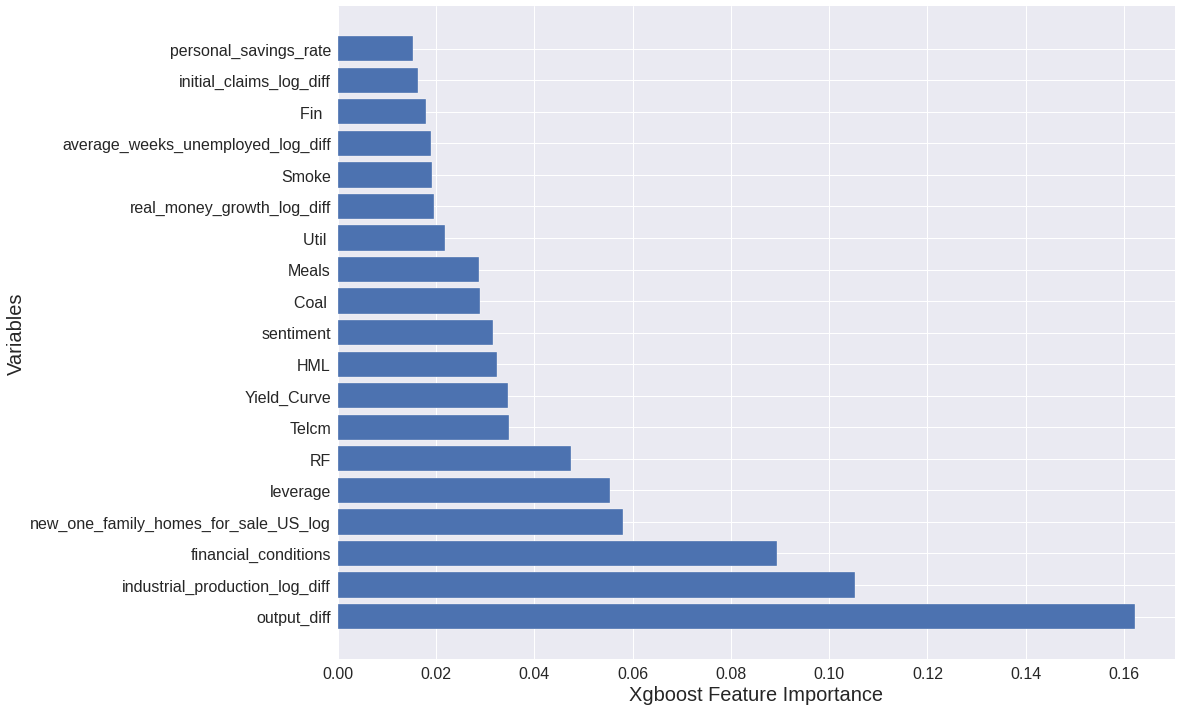

In [ ]:
sorted_idx = model.feature_importances_.argsort()[::-1]
plt.figure(figsize=(15,12))
#plt.barh(X_var.columns[sorted_idx][:10], model.feature_importances_[sorted_idx][:10])
plt.barh(X.columns[sorted_idx][:19], model.feature_importances_[sorted_idx][:19])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Variables", fontsize=20)
plt.xlabel("Xgboost Feature Importance", fontsize=20)

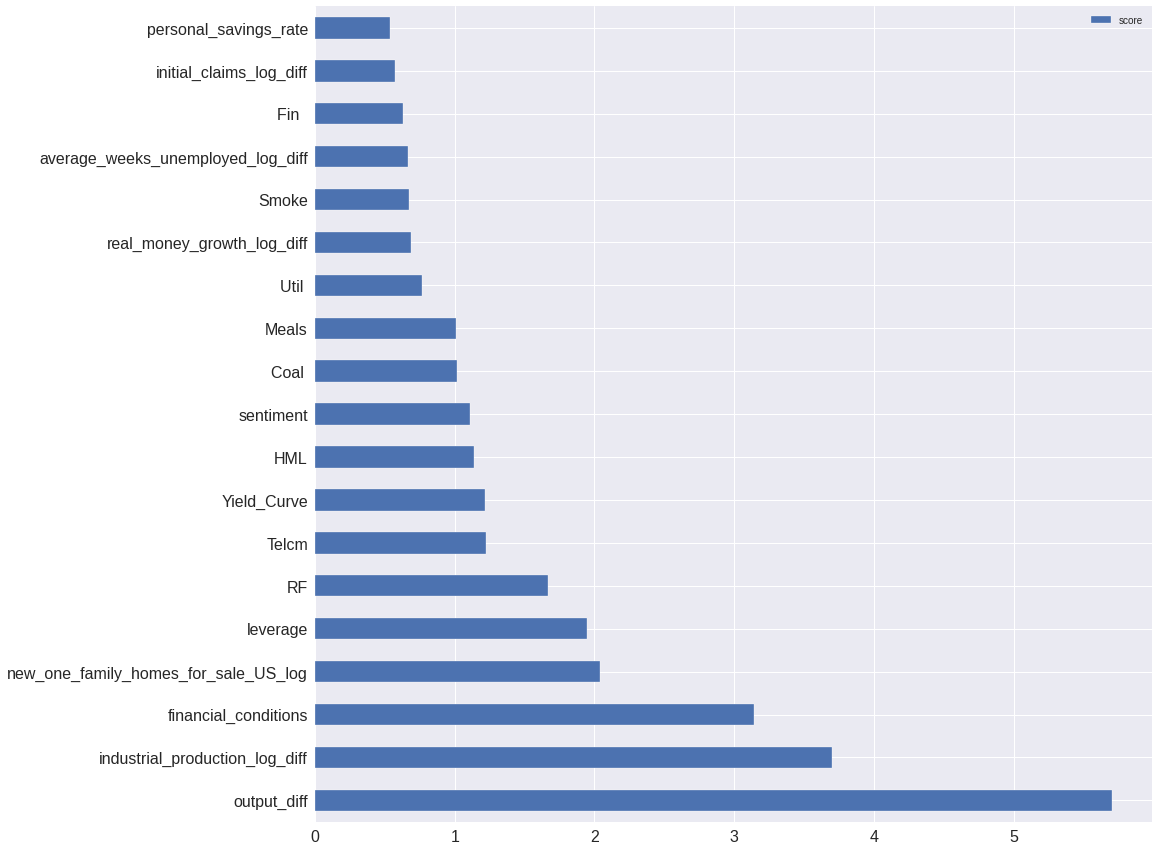

In [ ]:
feature_important2 = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important2.keys())
values = list(feature_important2.values())
plt.style.use('seaborn')
data2 = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data2.nlargest(19, columns="score").plot(kind='barh', figsize = (15,15), fontsize=16) ## plot top 40 features

In [ ]:
features_ = pd.DataFrame(importance_df[0].sort_values()).tail(19).reset_index()
features_ = features_.iloc[:,0]
features_

0               real_money_growth_log_diff
1                                    Beer 
2                              Yield_Curve
3                                       RF
4        average_weeks_unemployed_log_diff
5             new_housing_permits_log_diff
6                                    Mines
7                  initial_claims_log_diff
8                                sentiment
9                                      CMA
10                                   BusEq
11                                   Coal 
12                                   Games
13                   personal_savings_rate
14                    financial_conditions
15                                leverage
16          industrial_production_log_diff
17    new_one_family_homes_for_sale_US_log
18                             output_diff
Name: index, dtype: object

In [ ]:
plt.style.use('seaborn')

Text(0.5, 0, 'Xgboost Feature Importance')

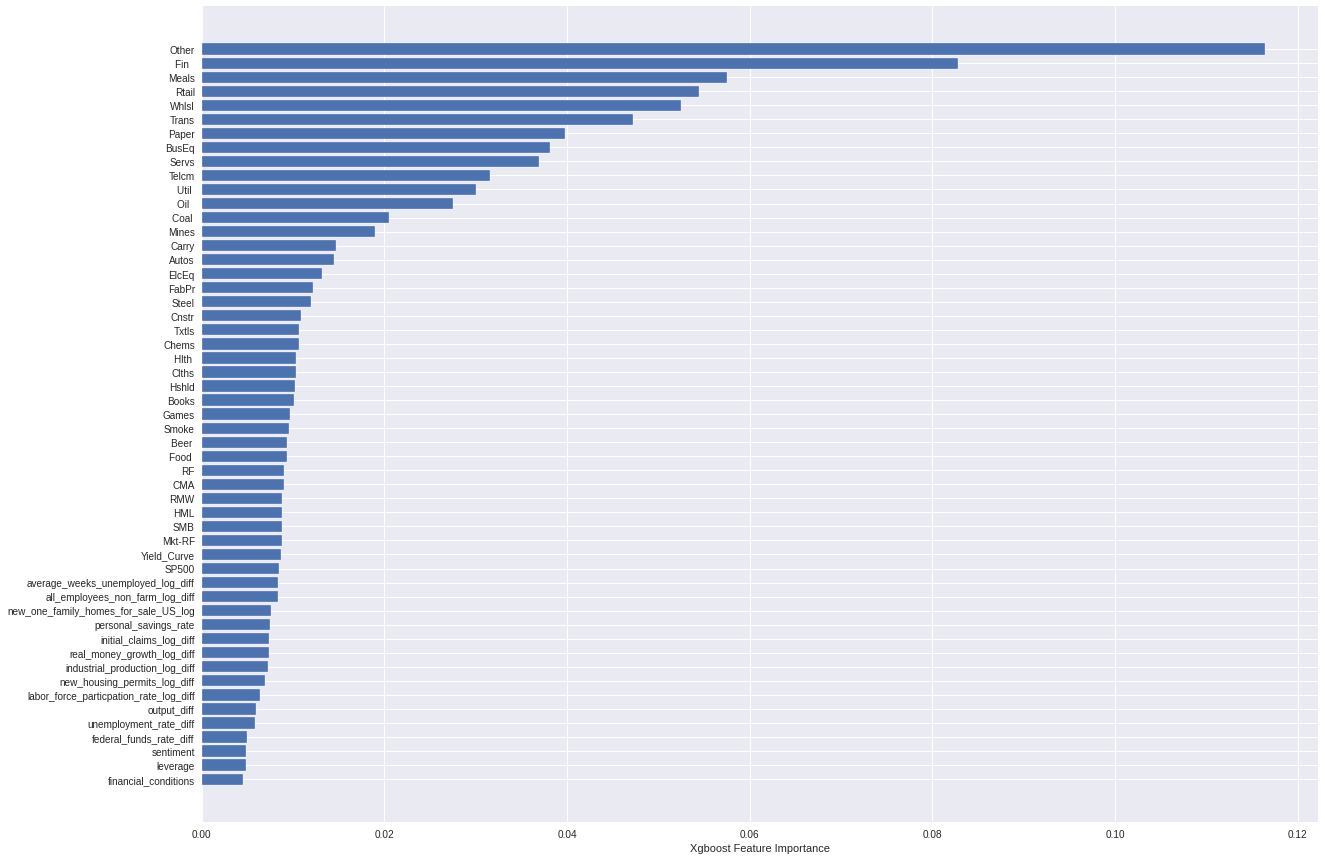

In [ ]:
sorted_idx = classifier.feature_importances_.argsort()
plt.figure(figsize=(20,15))
plt.barh(X.columns, classifier.feature_importances_[sorted_idx])

plt.xlabel("Xgboost Feature Importance")

In [ ]:
len(classifier.feature_importances_[sorted_idx])

53

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

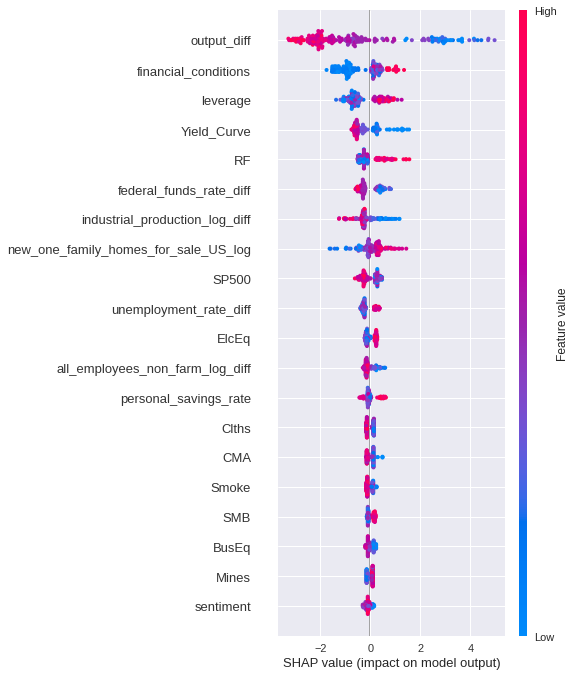

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
len(shap_values)

205

In [ ]:
explainer

In [ ]:
features_

0               real_money_growth_log_diff
1                                    Beer 
2                              Yield_Curve
3                                       RF
4        average_weeks_unemployed_log_diff
5             new_housing_permits_log_diff
6                                    Mines
7                  initial_claims_log_diff
8                                sentiment
9                                      CMA
10                                   BusEq
11                                   Coal 
12                                   Games
13                   personal_savings_rate
14                    financial_conditions
15                                leverage
16          industrial_production_log_diff
17    new_one_family_homes_for_sale_US_log
18                             output_diff
Name: index, dtype: object

In [ ]:
feat_list = []

In [ ]:
features_

0               real_money_growth_log_diff
1                                    Beer 
2                              Yield_Curve
3                                       RF
4        average_weeks_unemployed_log_diff
5             new_housing_permits_log_diff
6                                    Mines
7                  initial_claims_log_diff
8                                sentiment
9                                      CMA
10                                   BusEq
11                                   Coal 
12                                   Games
13                   personal_savings_rate
14                    financial_conditions
15                                leverage
16          industrial_production_log_diff
17    new_one_family_homes_for_sale_US_log
18                             output_diff
Name: index, dtype: object

In [ ]:
# remove special character
recession_data.columns = recession_data.columns.str.replace(' ', '')

In [ ]:
def plot_traces(traces, burnin=2000):
    summary = arviz.summary(traces[burnin:])['mean'].to_dict()
    ax = arviz.plot_trace(traces[burnin:],
                      figsize=(15, len(traces.varnames)*1.5),
                      lines=summary)

    for i, mn in enumerate(summary.values()):
        ax[i, 0].annotate(f'{mn:.2f}', xy=(mn, 0),
                          xycoords='data', xytext=(5, 10),
                          textcoords='offset points',
                          rotation=90, va='bottom',
                          fontsize='large',
                          color='#AA0022')

In [ ]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(r_model,
                            recession_data,
                            family=pm.glm.families.Binomial())

We recommend to instead use Bambi https://bambinos.github.io/bambi/


In [ ]:
logistic_model.basic_RVs

[Intercept ~ Flat,
 real_money_growth_log_diff ~ Normal,
 Yield_Curve ~ Normal,
 Beer ~ Normal,
 average_weeks_unemployed_log_diff ~ Normal,
 RF ~ Normal,
 new_housing_permits_log_diff ~ Normal,
 Mines ~ Normal,
 sentiment ~ Normal,
 initial_claims_log_diff ~ Normal,
 Coal ~ Normal,
 CMA ~ Normal,
 Games ~ Normal,
 BusEq ~ Normal,
 personal_savings_rate ~ Normal,
 financial_conditions ~ Normal,
 leverage ~ Normal,
 industrial_production_log_diff ~ Normal,
 new_one_family_homes_for_sale_US_log ~ Normal,
 output_diff ~ Normal,
 y ~ Binomial]

### Training the MCMC Model

In [ ]:
with logistic_model:
    trace_mh = pm.sample(tune=1000,
                         draws=5000,
                         step=pm.Metropolis(),
                         cores=4)

ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


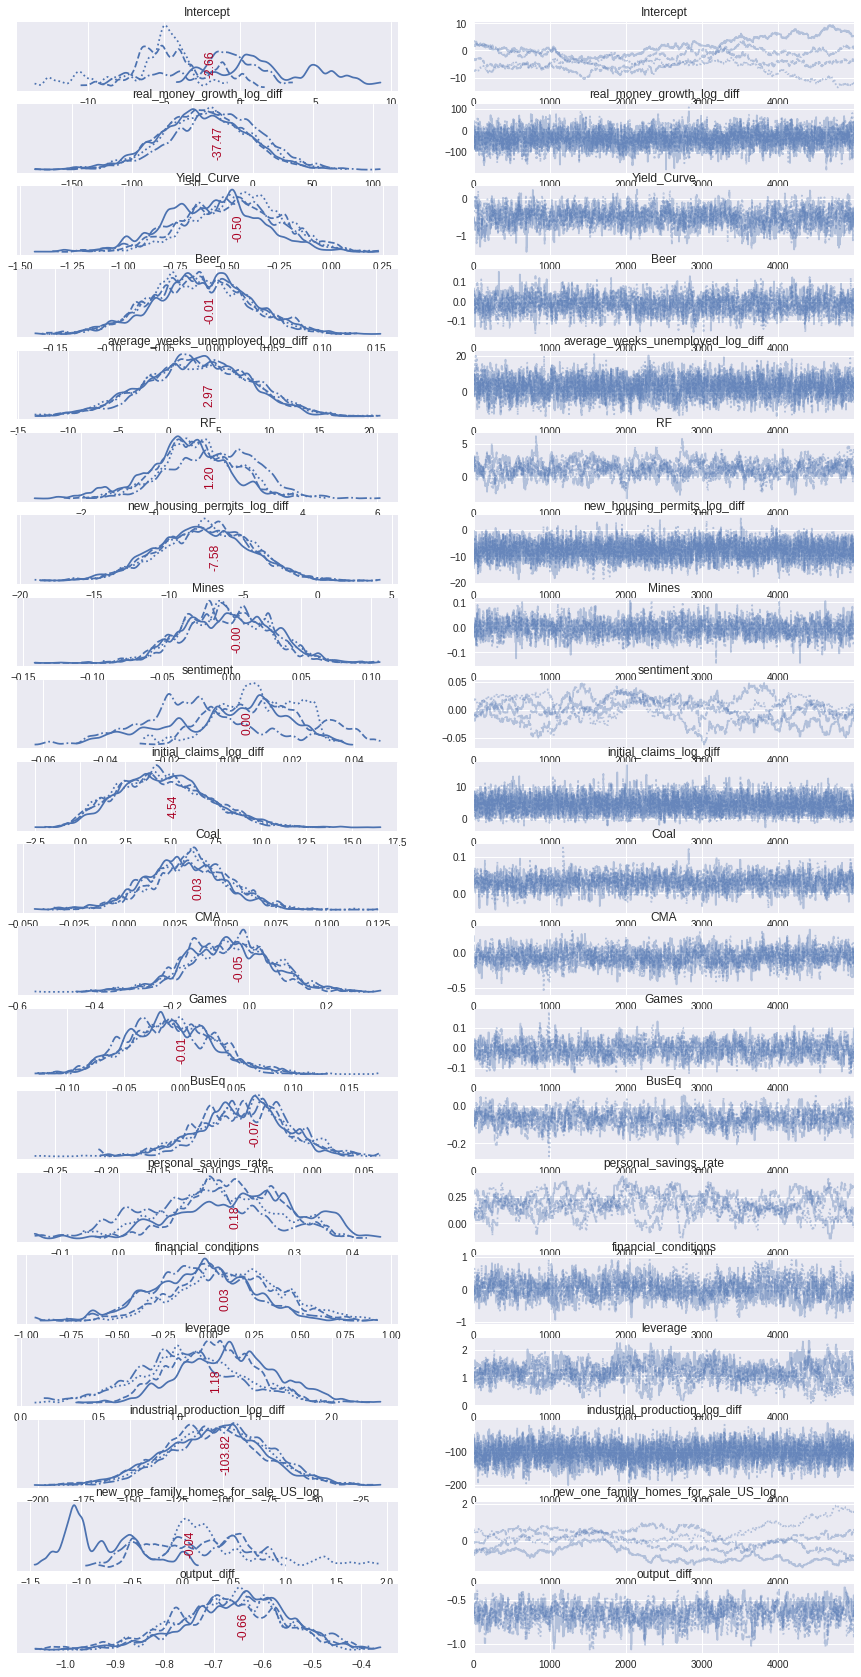

In [ ]:
plot_traces(trace_mh, burnin=0)

In [ ]:
pm.trace_to_dataframe(trace_mh).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Intercept                             20000 non-null  float64
 1   real_money_growth_log_diff            20000 non-null  float64
 2   Yield_Curve                           20000 non-null  float64
 3   Beer                                  20000 non-null  float64
 4   average_weeks_unemployed_log_diff     20000 non-null  float64
 5   RF                                    20000 non-null  float64
 6   new_housing_permits_log_diff          20000 non-null  float64
 7   Mines                                 20000 non-null  float64
 8   sentiment                             20000 non-null  float64
 9   initial_claims_log_diff               20000 non-null  float64
 10  Coal                                  20000 non-null  float64
 11  CMA            

In [ ]:
with logistic_model:
    trace_mh = pm.sample(draws=100000,
                         step=pm.Metropolis(),
                         trace=trace_mh)

ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


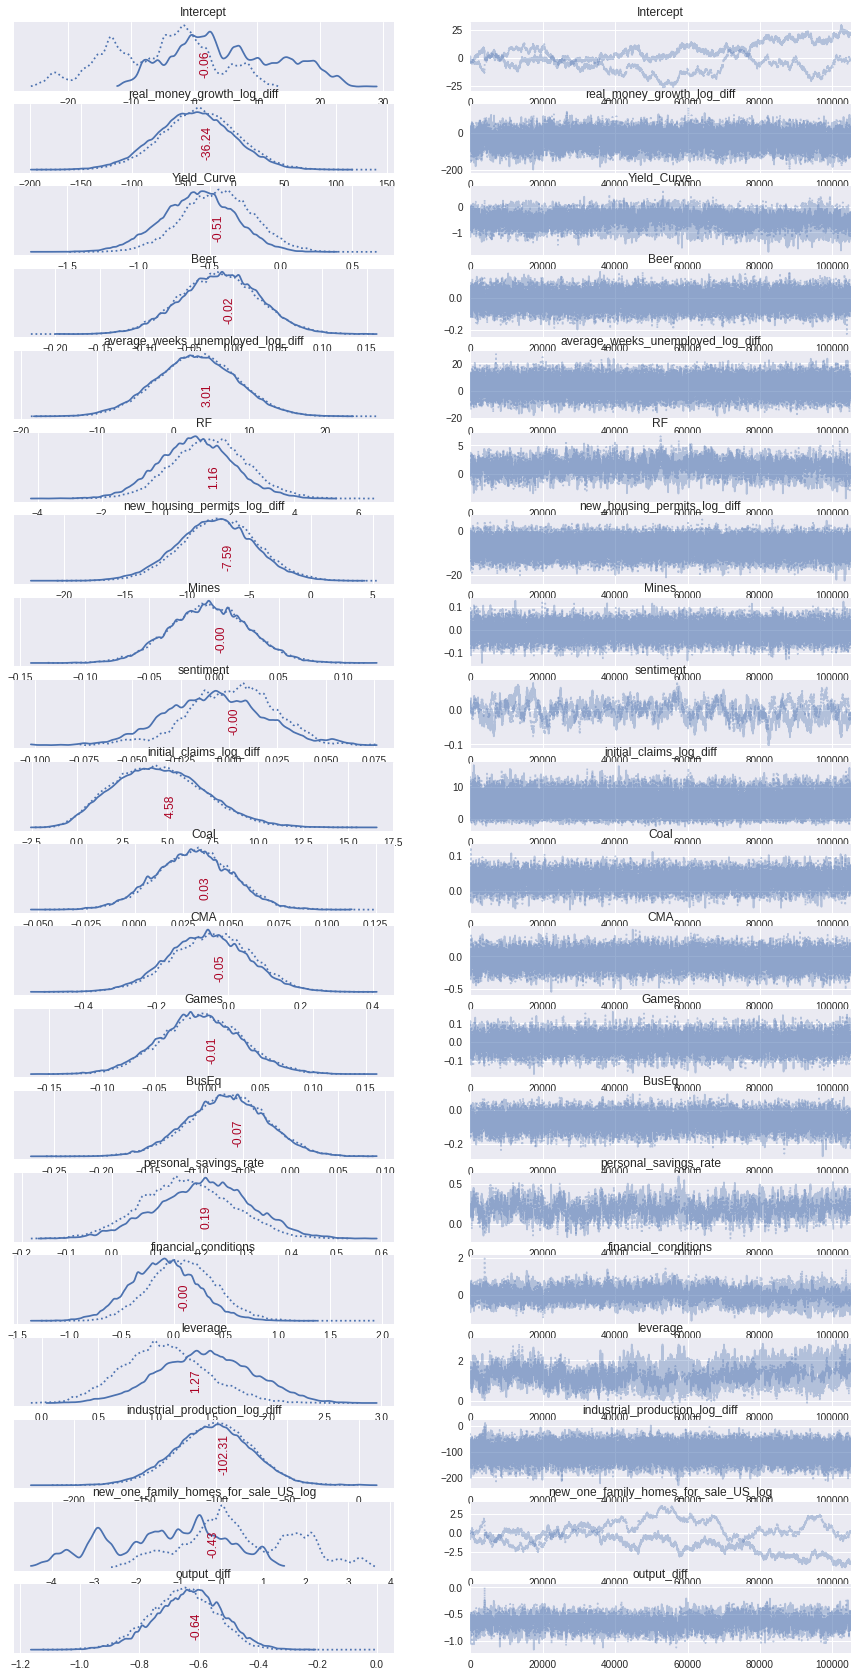

In [ ]:
plot_traces(trace_mh, burnin=0)

In [ ]:
arviz.summary(trace_mh)

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


mean      sd   hdi_3%  hdi_97%  \
Intercept                              -0.055  10.103  -18.098   19.927   
real_money_growth_log_diff            -36.238  37.633 -107.129   34.624   
Yield_Curve                            -0.513   0.262   -1.022   -0.030   
Beer                                   -0.016   0.045   -0.101    0.066   
average_weeks_unemployed_log_diff       3.011   5.369   -7.201   12.990   
RF                                      1.160   1.187   -1.114    3.369   
new_housing_permits_log_diff           -7.593   3.113  -13.571   -1.822   
Mines                                  -0.003   0.031   -0.060    0.055   
sentiment                              -0.003   0.024   -0.049    0.043   
initial_claims_log_diff                 4.580   2.504    0.003    9.128   
Coal                                    0.031   0.020   -0.006    0.069   
CMA                                    -0.051   0.112   -0.255    0.164   
Games                                  -0.006   0.039   -0.081    0.067   
BusEq                                  -0.067   0.042   -0.145    0.013   
personal_savings_rate                   0.187   0.104   -0.003    0.386   
financial_conditions                   -0.001   0.331   -0.620    0.621   
leverage                                1.267   0.437    0.458    2.093   
industrial_production_log_diff       -102.312  27.054 -152.794  -51.507   
new_one_family_homes_for_sale_US_log   -0.434   1.603   -3.677    2.314   
output_diff                            -0.644   0.113   -0.865   -0.442   

                                      mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                 5.488    4.275       4.0      13.0   
real_money_growth_log_diff                1.157    0.818    1058.0    6232.0   
Yield_Curve                               0.070    0.051      14.0      48.0   
Beer                                      0.000    0.000   12507.0   20219.0   
average_weeks_unemployed_log_diff         0.057    0.040    8977.0   22051.0   
RF                                        0.162    0.115      54.0    2321.0   
new_housing_permits_log_diff              0.037    0.029    7122.0   29363.0   
Mines                                     0.000    0.000    9458.0   15009.0   
sentiment                                 0.004    0.003      40.0     252.0   
initial_claims_log_diff                   0.019    0.013   17961.0   33530.0   
Coal                                      0.000    0.000    9507.0   15379.0   
CMA                                       0.001    0.001    5614.0   18837.0   
Games                                     0.000    0.000    6557.0   12915.0   
BusEq                                     0.001    0.000    5738.0   12705.0   
personal_savings_rate                     0.008    0.006     177.0    1153.0   
financial_conditions                      0.095    0.069      12.0      44.0   
leverage                                  0.179    0.135       6.0      22.0   
industrial_production_log_diff            0.567    0.401    2306.0    7986.0   
new_one_family_homes_for_sale_US_log      0.880    0.687       3.0      13.0   
output_diff                               0.009    0.006     158.0    2014.0   

                                      r_hat  
Intercept                              1.57  
real_money_growth_log_diff             1.00  
Yield_Curve                            1.09  
Beer                                   1.00  
average_weeks_unemployed_log_diff      1.00  
RF                                     1.04  
new_housing_permits_log_diff           1.01  
Mines                                  1.00  
sentiment                              1.07  
initial_claims_log_diff                1.00  
Coal                                   1.00  
CMA                                    1.00  
Games                                  1.00  
BusEq                                  1.00  
personal_savings_rate                  1.03  
financial_conditions                   1.11  
le

In [ ]:
draws = 100
tune = 1000
with logistic_model:
    trace_NUTS = pm.sample(draws=draws,
                           tune=tune,
                           init='adapt_diag',
                           chains=4,
                           cores=1,
                           random_seed=42)

ERROR:pymc3:There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 35 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
trace_df = pm.trace_to_dataframe(trace_NUTS).assign(
    chain=lambda x: x.index // draws)
trace_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Intercept                             400 non-null    float64
 1   real_money_growth_log_diff            400 non-null    float64
 2   Yield_Curve                           400 non-null    float64
 3   Beer                                  400 non-null    float64
 4   average_weeks_unemployed_log_diff     400 non-null    float64
 5   RF                                    400 non-null    float64
 6   new_housing_permits_log_diff          400 non-null    float64
 7   Mines                                 400 non-null    float64
 8   sentiment                             400 non-null    float64
 9   initial_claims_log_diff               400 non-null    float64
 10  Coal                                  400 non-null    float64
 11  CMA                

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


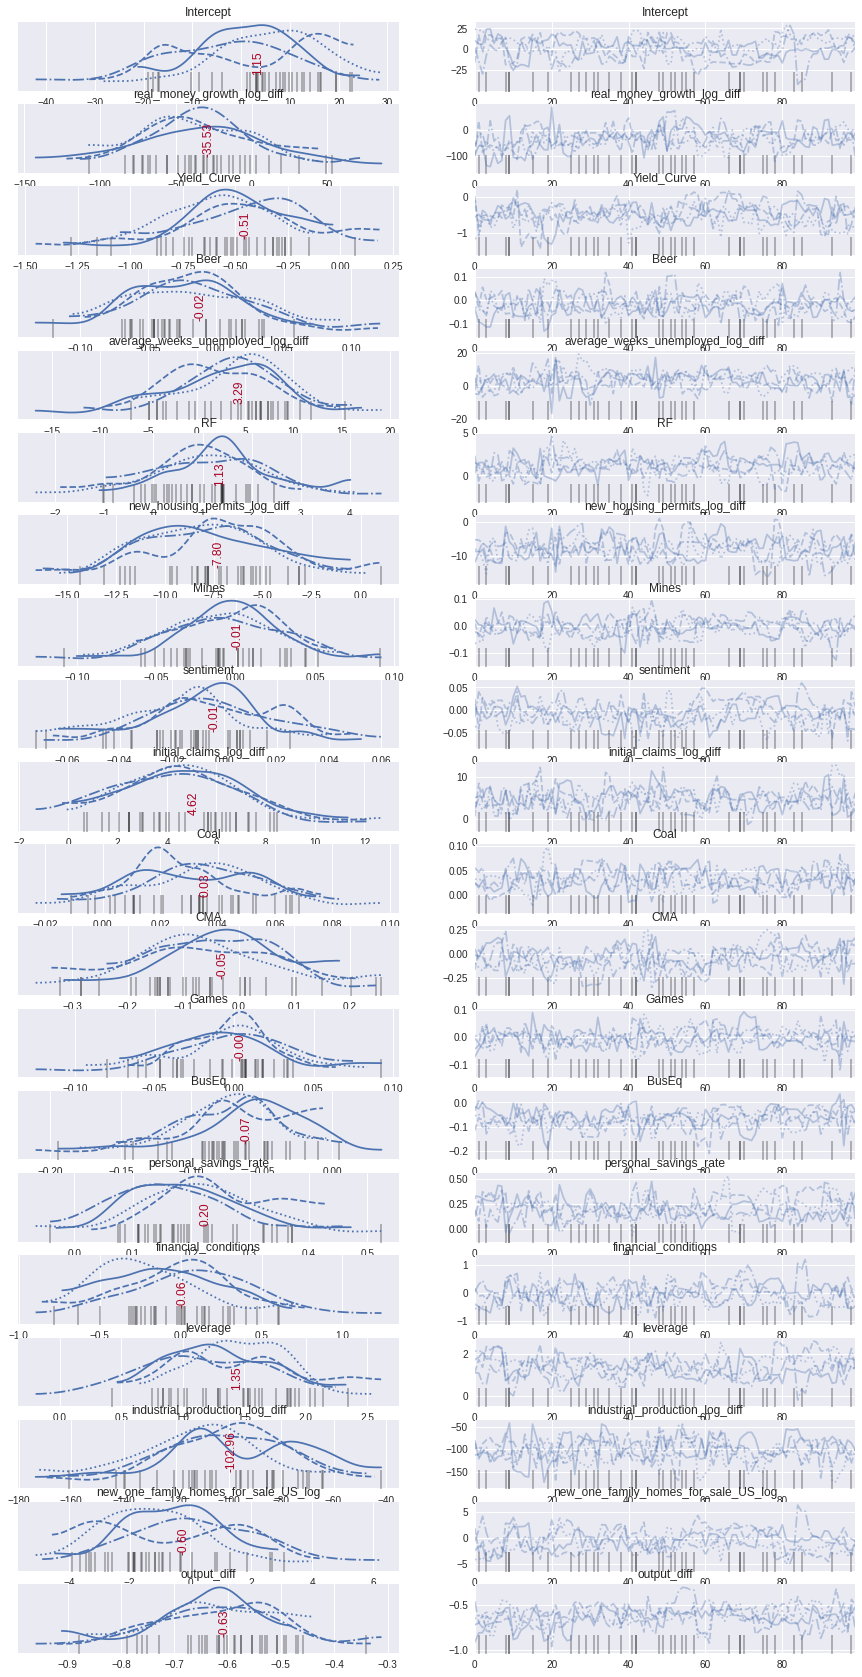

In [ ]:
plot_traces(trace_NUTS, burnin=0)

In [ ]:
draws = 50000
chains = 4
with logistic_model:
    trace_NUTS = pm.sample(draws=draws, 
                           tune=tune,
                           init='adapt_diag',
                           trace=trace_NUTS,
                           chains=chains, 
                           cores=1,
                           random_seed=42)

ERROR:pymc3:There were 4844 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 13520 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 18866 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 20438 divergences after tuning. Increase `target_accept` or reparameterize.


ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


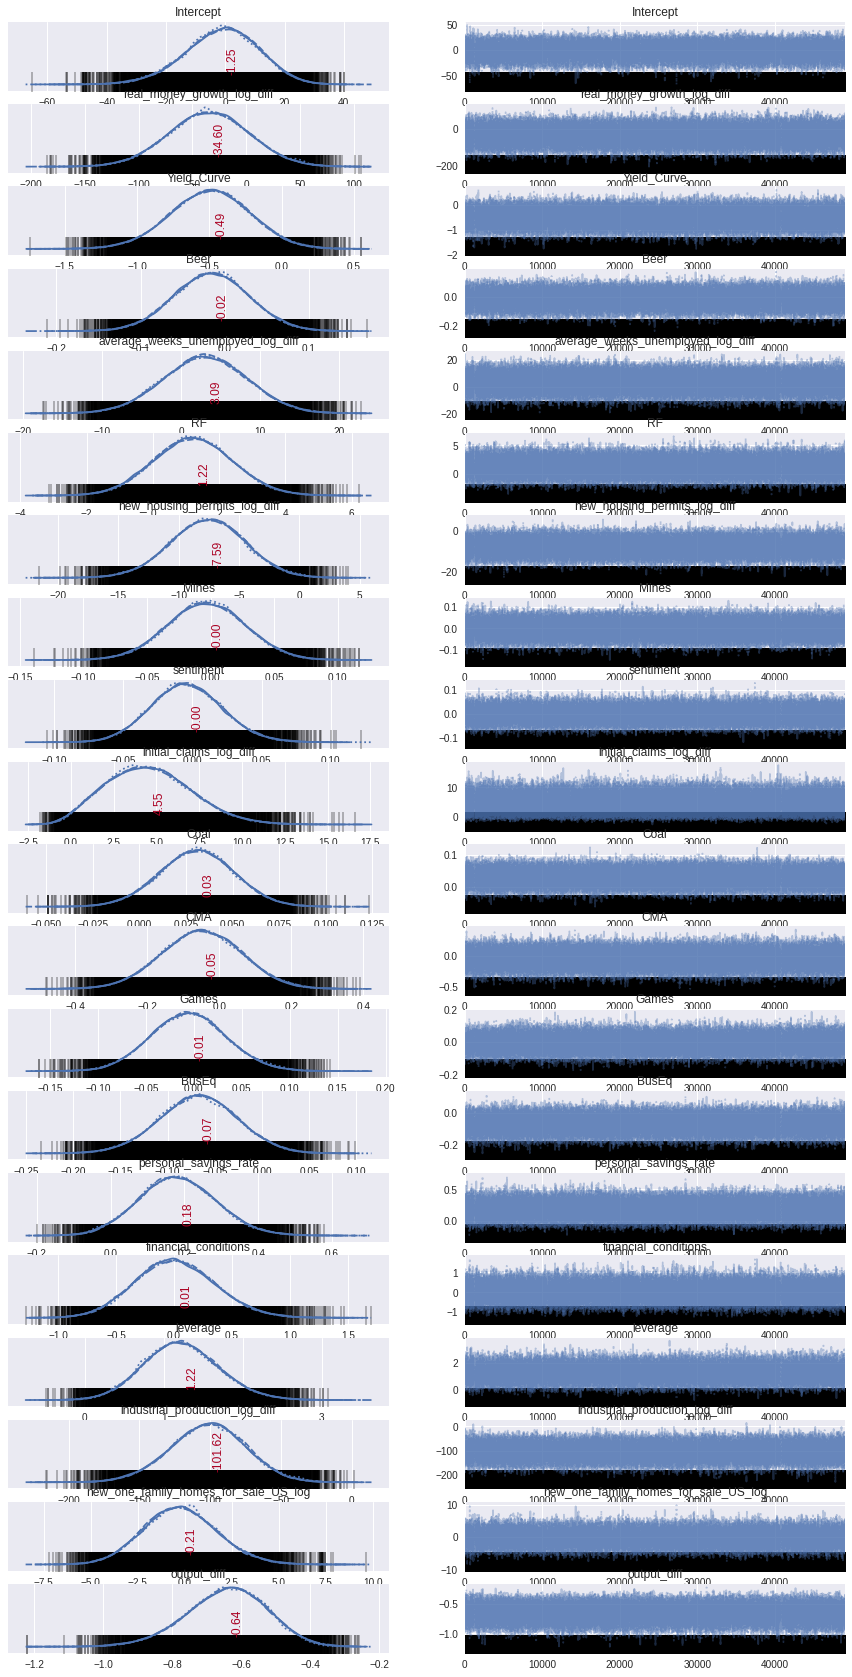

In [ ]:

plot_traces(trace_NUTS, burnin=1000)

In [ ]:
df = pm.trace_to_dataframe(trace_NUTS).iloc[200:].reset_index(
    drop=True).assign(chain=lambda x: x.index // draws)
trace_df = pd.concat([trace_df.assign(samples=100),
                      df.assign(samples=len(df) + len(trace_df))])
trace_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200600 entries, 0 to 200199
Data columns (total 22 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Intercept                             200600 non-null  float64
 1   real_money_growth_log_diff            200600 non-null  float64
 2   Yield_Curve                           200600 non-null  float64
 3   Beer                                  200600 non-null  float64
 4   average_weeks_unemployed_log_diff     200600 non-null  float64
 5   RF                                    200600 non-null  float64
 6   new_housing_permits_log_diff          200600 non-null  float64
 7   Mines                                 200600 non-null  float64
 8   sentiment                             200600 non-null  float64
 9   initial_claims_log_diff               200600 non-null  float64
 10  Coal                                  200600 non-null  float64
 11  

In [ ]:
trace_df_long = pd.melt(trace_df, id_vars=['samples', 'chain'])
trace_df_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4012000 entries, 0 to 4011999
Data columns (total 4 columns):
 #   Column    Dtype  
---  ------    -----  
 0   samples   int64  
 1   chain     int64  
 2   variable  object 
 3   value     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 122.4+ MB


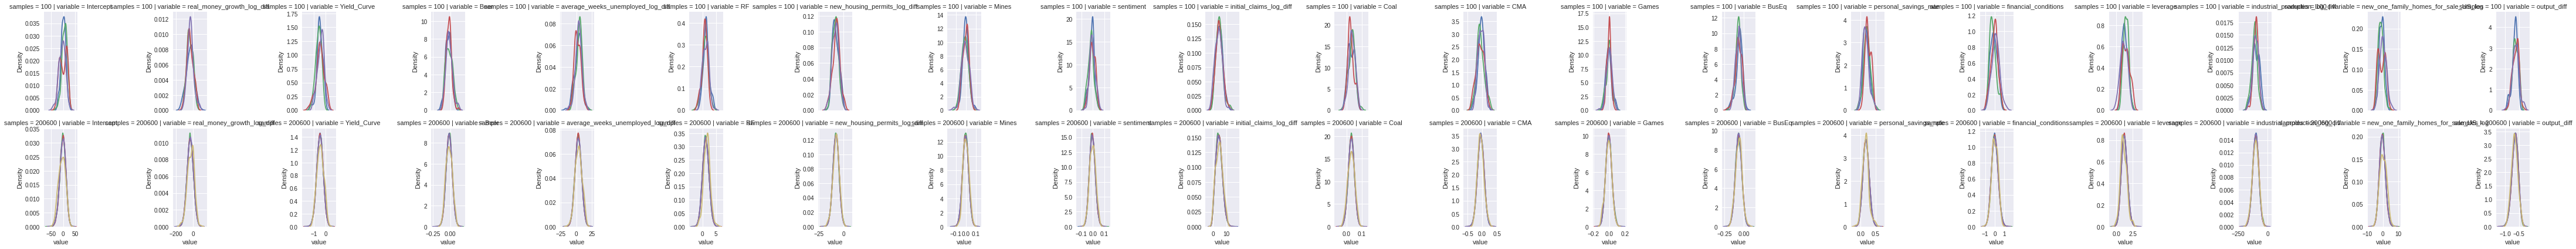

In [ ]:
g = sns.FacetGrid(trace_df_long, col='variable', row='samples',
                  hue='chain', sharex='col', sharey=False)
g = g.map(sns.distplot, 'value', hist=False, rug=False);

In [ ]:
model = smf.logit(formula=r_model, data=recession_data)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.179944
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              recession   No. Observations:                  621
Model:                          Logit   Df Residuals:                      601
Method:                           MLE   Df Model:                           19
Date:                Wed, 23 Nov 2022   Pseudo R-squ.:                  0.5971
Time:                        21:04:31   Log-Likelihood:                -111.75
converged:                       True   LL-Null:                       -277.37
Covariance Type:            nonrobust   LLR p-value:                 7.557e-59
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.3386     11.6

In [ ]:
arviz.summary(trace_NUTS).assign(statsmodels=result.params).to_csv(model_path / 'trace_nuts.csv')

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


In [ ]:

arviz.summary(trace_NUTS).assign(statsmodels=result.params)

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


mean      sd   hdi_3%  hdi_97%  \
Intercept                              -1.252  12.447  -25.064   21.775   
real_money_growth_log_diff            -34.566  37.736 -105.597   36.582   
Yield_Curve                            -0.495   0.277   -1.018    0.025   
Beer                                   -0.016   0.045   -0.099    0.069   
average_weeks_unemployed_log_diff       3.089   5.320   -6.897   13.115   
RF                                      1.220   1.191   -1.027    3.447   
new_housing_permits_log_diff           -7.592   3.107  -13.507   -1.770   
Mines                                  -0.003   0.031   -0.061    0.055   
sentiment                              -0.004   0.026   -0.053    0.045   
initial_claims_log_diff                 4.547   2.473   -0.017    9.034   
Coal                                    0.031   0.020   -0.007    0.069   
CMA                                    -0.049   0.112   -0.263    0.158   
Games                                  -0.005   0.040   -0.080    0.069   
BusEq                                  -0.068   0.042   -0.146    0.011   
personal_savings_rate                   0.181   0.105   -0.017    0.376   
financial_conditions                    0.014   0.347   -0.629    0.676   
leverage                                1.222   0.474    0.340    2.120   
industrial_production_log_diff       -101.618  26.771 -152.122  -51.184   
new_one_family_homes_for_sale_US_log   -0.211   1.960   -3.807    3.579   
output_diff                            -0.643   0.117   -0.862   -0.425   

                                      mcse_mean  mcse_sd  ess_bulk  ess_tail  \
Intercept                                 0.071    0.050   31184.0   39662.0   
real_money_growth_log_diff                0.185    0.131   41678.0   19289.0   
Yield_Curve                               0.001    0.001   41313.0   30944.0   
Beer                                      0.000    0.000   62958.0   54514.0   
average_weeks_unemployed_log_diff         0.021    0.015   65450.0   76339.0   
RF                                        0.005    0.004   56163.0   74640.0   
new_housing_permits_log_diff              0.014    0.010   50259.0   40833.0   
Mines                                     0.000    0.000   68966.0   80444.0   
sentiment                                 0.000    0.000   40663.0   54642.0   
initial_claims_log_diff                   0.010    0.007   68006.0   72279.0   
Coal                                      0.000    0.000   62421.0   74159.0   
CMA                                       0.000    0.000   57058.0   59597.0   
Games                                     0.000    0.000   39657.0   12675.0   
BusEq                                     0.000    0.000   43816.0   33654.0   
personal_savings_rate                     0.001    0.000   38359.0   19728.0   
financial_conditions                      0.002    0.001   38970.0   60316.0   
leverage                                  0.003    0.002   28690.0   20926.0   
industrial_production_log_diff            0.157    0.111   28061.0   12291.0   
new_one_family_homes_for_sale_US_log      0.011    0.008   30464.0   38452.0   
output_diff                               0.001    0.000   39719.0   45844.0   

                                      r_hat  statsmodels  
Intercept                               1.0     0.338581  
real_money_growth_log_diff              1.0   -32.117757  
Yield_Curve                             1.0    -0.484975  
Beer                                    1.0    -0.014828  
average_weeks_unemployed_log_diff       1.0     3.323364  
RF                                      1.0     1.148126  
new_housing_permits_log_diff            1.0    -6.902646  
Mines                                   1.0    -0.003268  
sentiment                               1.0    -0.008530  
initial_claims_log_diff                 1.0     3.892263  
Coal                                    1.0     0.028849  
CMA                                     1.0    -0.041736  
Games            

In [ ]:
def get_credible_int(trace, param):
    b = trace[param]
    lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
    lb, ub = np.exp(lb), np.exp(ub)
    return b, lb, ub


In [ ]:
b = trace_NUTS['Yield_Curve']
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)
lb, ub = np.exp(lb), np.exp(ub)
print(f'P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')

P(0.351 < Odds Ratio < 1.041) = 0.95


In [ ]:

b, lb, ub = get_credible_int(trace_NUTS, 'Yield_Curve')
print(f'P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')

P(0.351 < Odds Ratio < 1.041) = 0.95


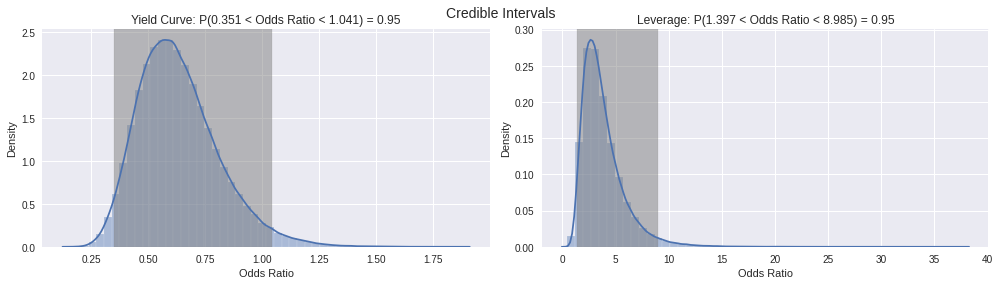

In [ ]:
fig, axes = plt.subplots(figsize=(14, 4), ncols=2)
b, lb, ub = get_credible_int(trace_NUTS, 'Yield_Curve')
sns.distplot(np.exp(b), axlabel='Odds Ratio', ax=axes[0])
axes[0].set_title(f'Yield Curve: P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')
axes[0].axvspan(lb, ub, alpha=0.5, color='gray')

b, lb, ub = get_credible_int(trace_NUTS, 'leverage')
sns.distplot(np.exp(b), axlabel='Odds Ratio', ax=axes[1])
axes[1].set_title(f'Leverage: P({lb:.3f} < Odds Ratio < {ub:.3f}) = 0.95')
axes[1].axvspan(lb, ub, alpha=0.5, color='gray')

fig.suptitle('Credible Intervals', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


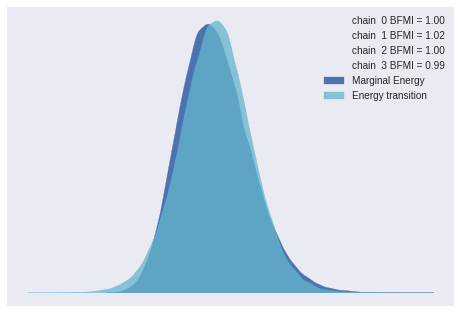

In [ ]:
arviz.plot_energy(trace_NUTS);

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


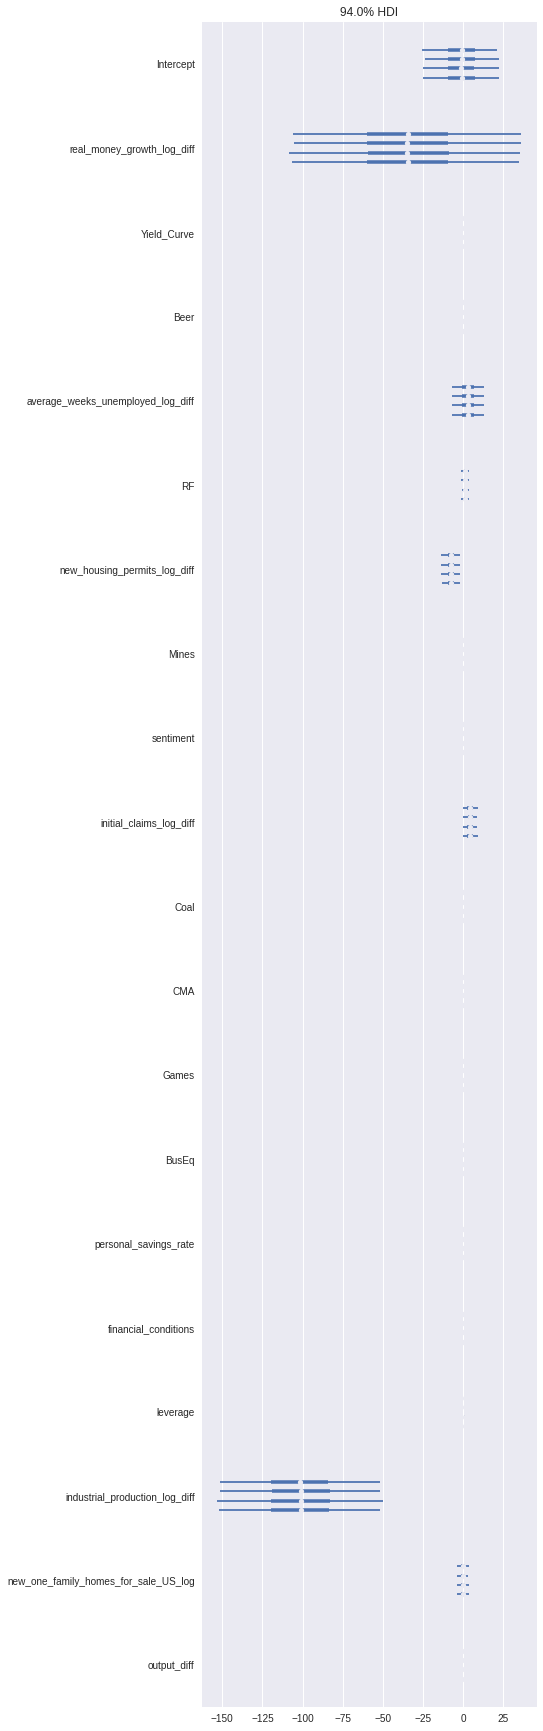

In [ ]:

arviz.plot_forest(trace_NUTS);

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


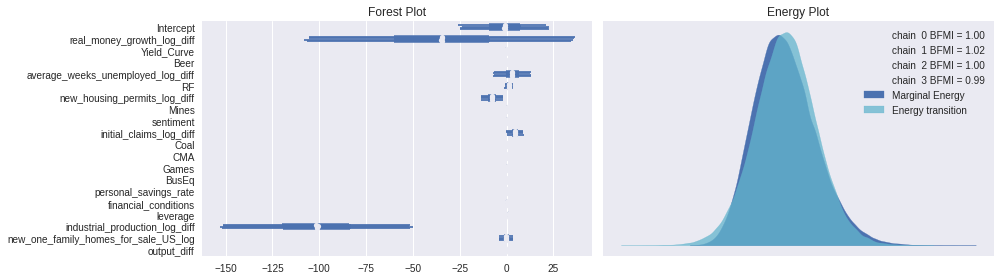

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
arviz.plot_forest(trace_NUTS, ax=axes[0])
axes[0].set_title('Forest Plot')

arviz.plot_energy(trace_NUTS, ax=axes[1])
axes[1].set_title('Energy Plot')

fig.tight_layout();

In [ ]:
ppc = pm.sample_posterior_predictive(trace_NUTS, samples=500, model=logistic_model)

In [ ]:

ppc['y'].shape

(500, 621)

In [ ]:

y_score = np.mean(ppc['y'], axis=0)

In [ ]:
roc_auc_score(y_score=np.mean(ppc['y'], axis=0), 
              y_true=recession_data.recession)

0.9637594922362008

In [ ]:
X = recession_data[['Yield_Curve']]
labels = X.columns
y = recession_data.recession
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)

In [ ]:

X_shared = theano.shared(X_train.values)

In [ ]:
with pm.Model() as logistic_model_pred:
    pm.glm.GLM(x=X_shared, 
               labels=labels,
               y=y_train, 
               family=pm.glm.families.Binomial())

In [ ]:
with logistic_model_pred:
    pred_trace = pm.sample(draws=10000, 
                           tune=1000,
                           chains=2,
                           cores=1,
                           init='adapt_diag')

In [ ]:

X_shared.set_value(X_test)

In [ ]:

ppc = pm.sample_posterior_predictive(pred_trace,
                                     model=logistic_model_pred,
                                     samples=100)

In [ ]:
y_score = np.mean(ppc['y'], axis=0)
roc_auc_score(y_score=np.mean(ppc['y'], axis=0), 
              y_true=y_test)

0.7756410256410257

In [ ]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

### Graph represents probaility of recession occuring, given feature variables.

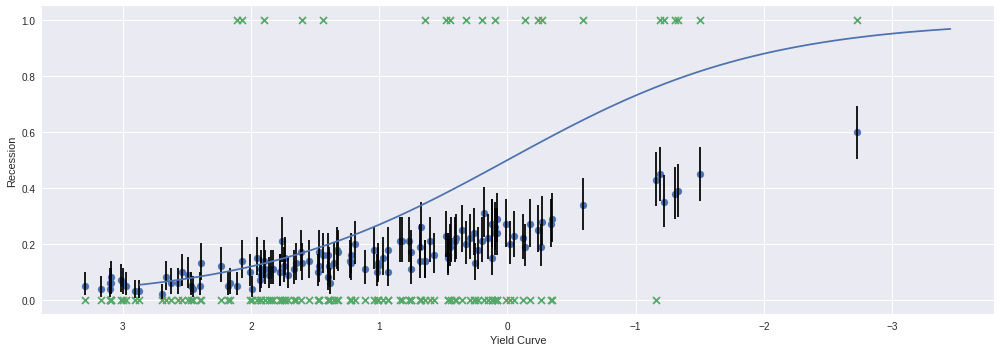

In [ ]:
x = X_test.Yield_Curve

fig, ax = plt.subplots(figsize=(14, 5))

β = stats.beta((ppc['y'] == 1).sum(axis=0), (ppc['y'] == 0).sum(axis=0))

# estimated probability
ax.scatter(x=x, y=β.mean())

# error bars on the estimate
plt.vlines(x, *β.interval(0.95))

# actual outcomes
ax.scatter(x=x, y=y_test, marker='x')

# True probabilities
x_ = np.linspace(x.min()*1.05, x.max()*1.05, num=100)
ax.plot(-x_, invlogit(x_), linestyle='-')

ax.set_xlabel('Yield Curve')
ax.set_ylabel('Recession')
ax.invert_xaxis()
fig.tight_layout();